# 第八章 思维骨架提示

<div class="toc">
 <ul class="toc-item">
     <li><span><a href="#一、引言" data-toc-modified-id="一、引言">一、引言</a></span></li>
     <li>
         <span><a href="#二、思维骨架提示" data-toc-modified-id="二、思维骨架提示">二、思维骨架提示</a></span>
         <ul class="toc-item">
             <li><span><a href="##2.1 骨架提示模板" data-toc-modified-id="2.1 骨架提示模板">2.1 骨架提示模板</a></span></li>
             <li><span><a href="##2.2 要点展开模板" data-toc-modified-id="2.2 要点展开模板">2.2 要点展开模板</a></span></li>
             <li><span><a href="##2.3 骨架提示和要点展开合并模板" data-toc-modified-id="2.3 骨架提示和要点展开合并模板">2.3 骨架提示和要点展开合并模板</a></span></li>
             </ul>
         </li>
     <li><span><a href="#三、总结与讨论" data-toc-modified-id="三、总结与讨论">三、总结与讨论</a></span></li>
     </ul>
</div>

## 一、引言
***

**人类如何高效地回答问题？**我们并不总是按顺序思考问题，然后给出答案。相反，我们通常会首先根据一些策略为各种类型的问题构建一个思考的框架，然后在此基础上添加细节以进一步阐述。在提供咨询、参加考试或撰写论文等正式场合中，这一点尤其重要。我们能否让大语言模型（Large Language Models, LLMs）以这样的方式进行思考？

**受人类思考和写作过程的启发**，清华和微软的研究者提出了「**思维骨架**」（Skeleton of Thought，SoT）。SoT 是以数据为中心优化推理效率的初步尝试，并展示了通过明确规划语言中的答案结构来获得高质量答案的潜力。相应的论文成功发表于 ICLR 2024 - [Skeleton-of-Thought: Large Language Models Can Do Parallel Decoding](https://openreview.net/forum?id=mqVgBbNCm9)



具体来说，我们可以引导 LLM 首先构建出一个思维骨架。在这个骨架的基础上，LLM 可以并行处理每个部分，从而提高处理速度。SoT 不仅可以用于加速开源模型的分批解码，还可以用于加速闭源模型的并行 API 调用。下面是思维骨架 (SoT) 的示意图。

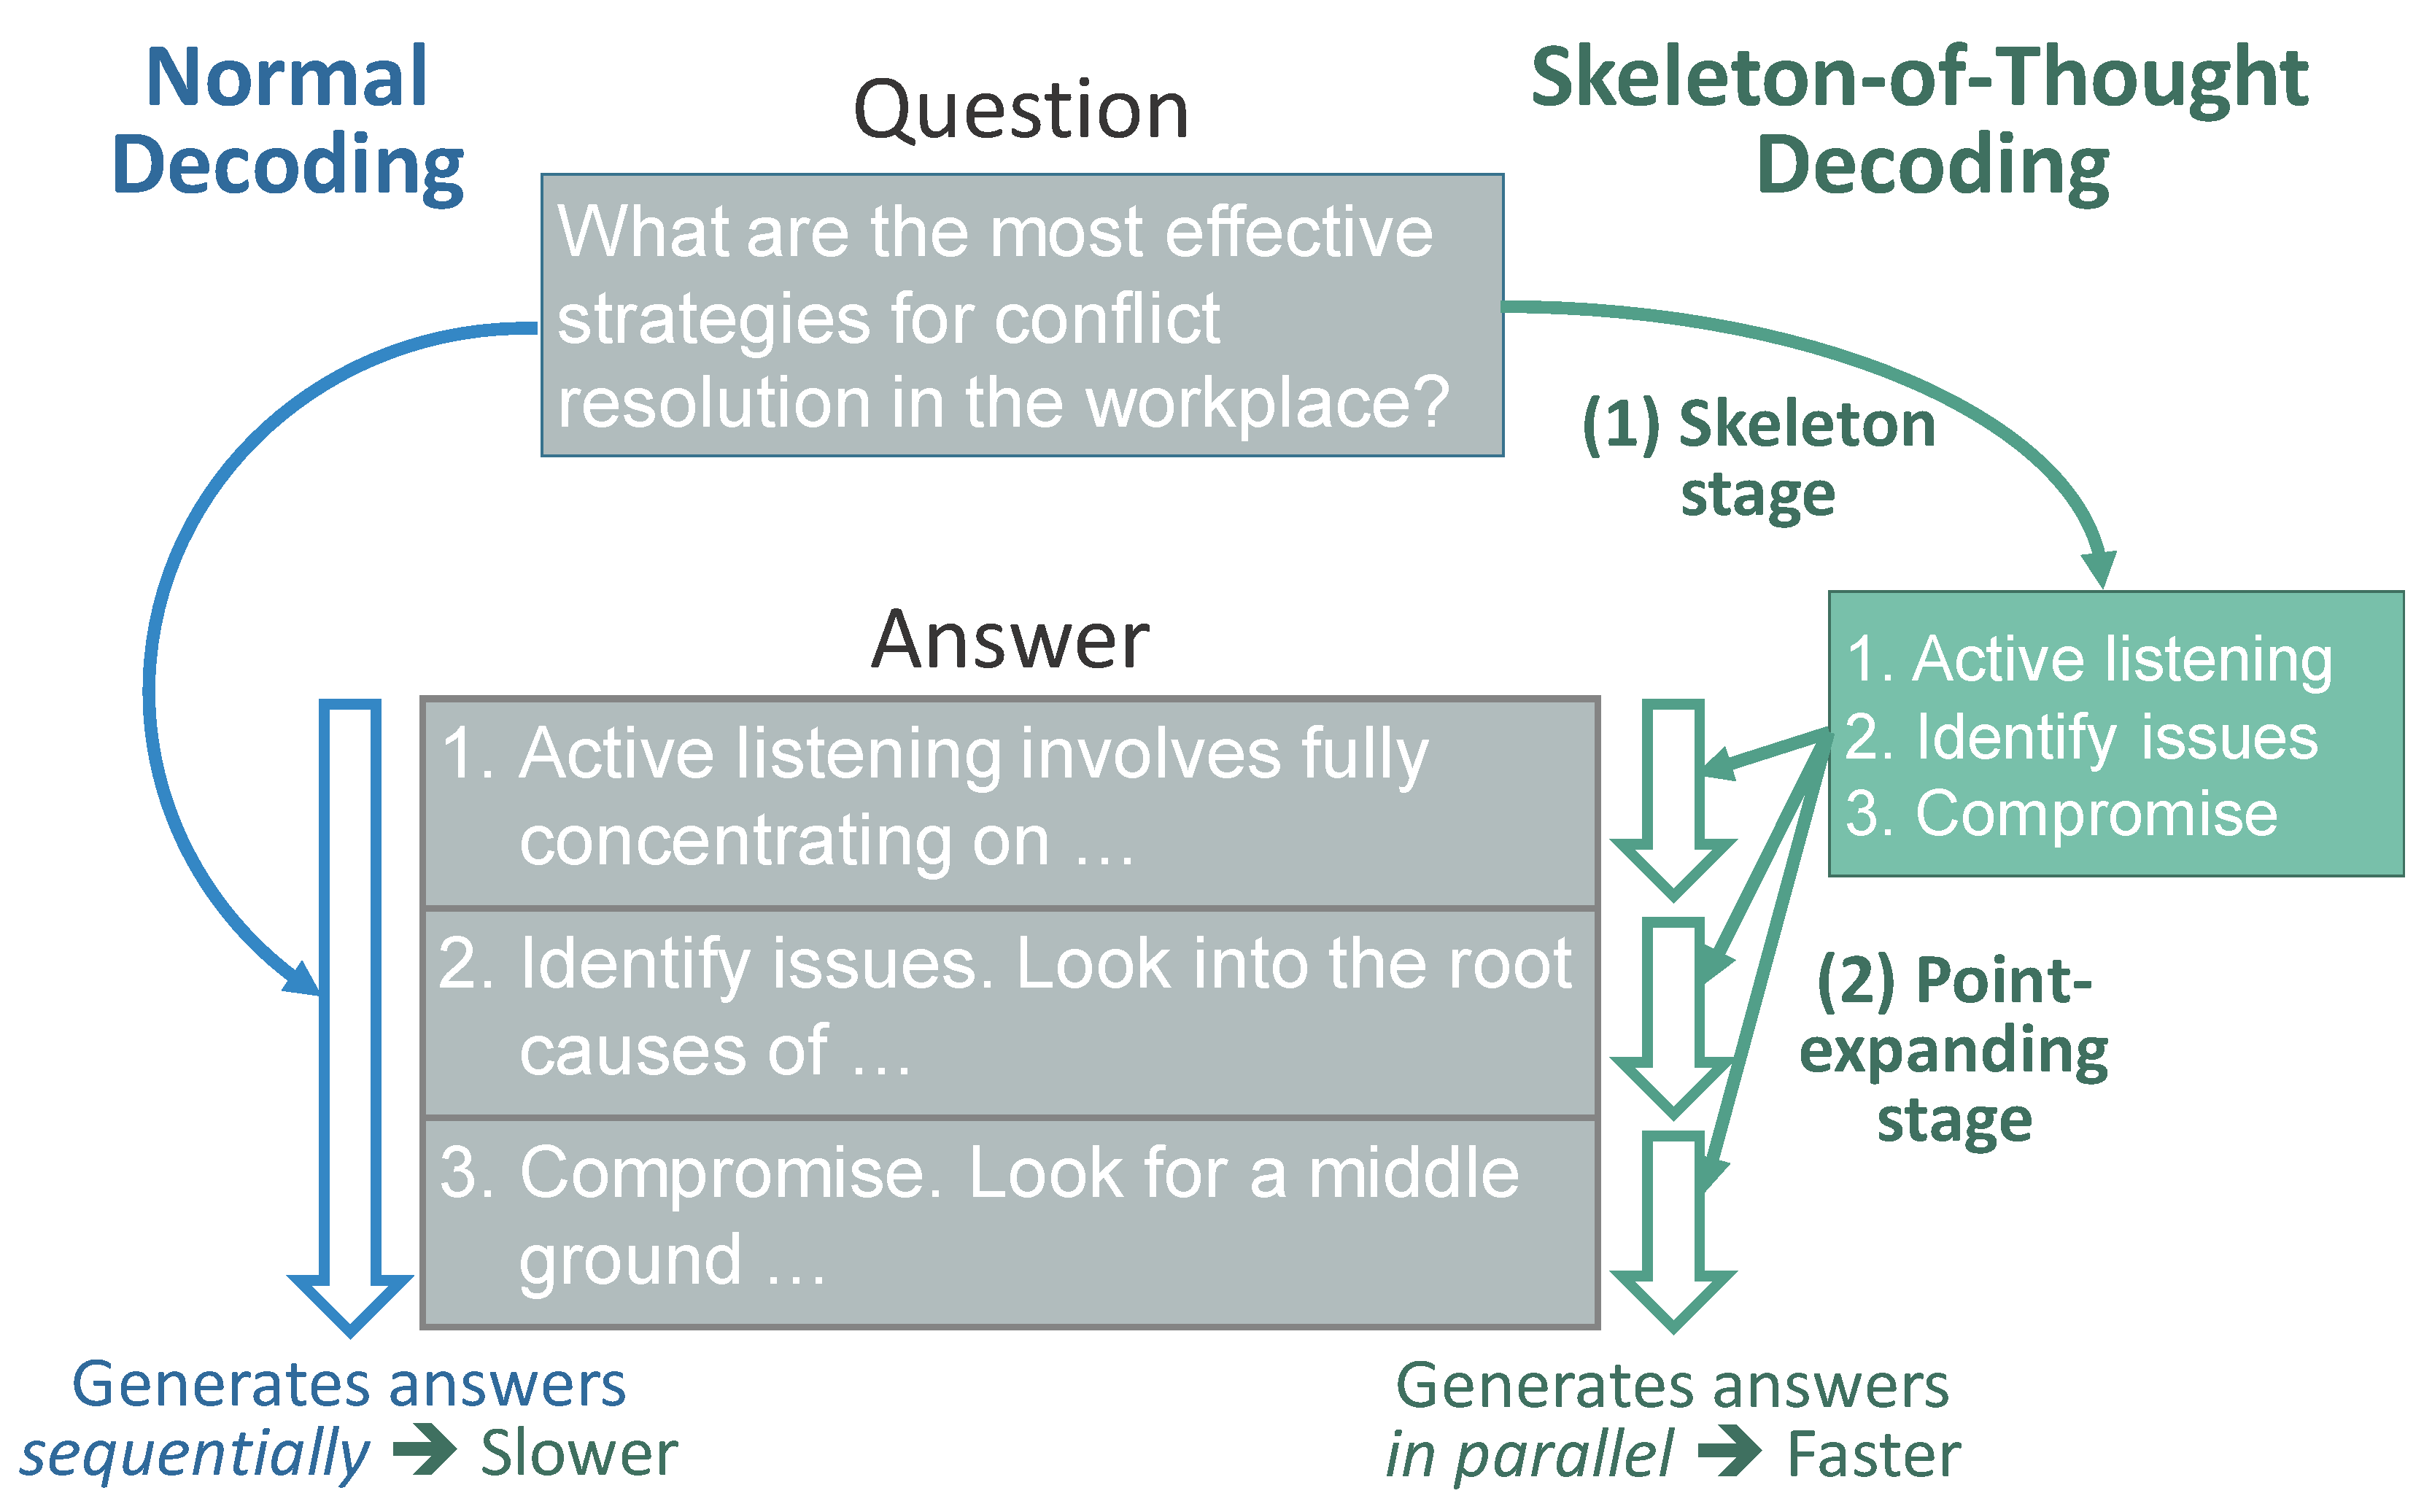

（1）SoT 并不是按顺序生成答案，而是并行地生成答案的不同部分。

（2）更具体地说，当问题给定时，**SoT 会首先引导 LLM 构建思维骨架**，然后进行批量解码或并行 API 调用以并行扩展多个要点，最后汇总输出结果以得出最终答案。

（3）需要注意的是，**目前的 SoT 适用于需要较长答案的问题，这些问题的结构可以提前规划，但不适用于需要逐步推理或只需要简短答案的问题**。

本章将详细介绍思维骨架提示。我们将深入阐述关键原理，并提供实际的代码示例，以帮助读者全面理解并掌握思维骨架提示 的关键原理和实际应用。阅读本章后，读者将能够更专业、准确地理解和应用思维骨架提示。

## 二、思维骨架提示
***

注意：我使用的测试环境是 Anaconda + Python 3.8.10。Python 的版本要求 Python 3.7+。

开始实验之前，我们需要安装好本次实验所需的第三方依赖库：`openai`：OpenAI Python 库提供了一个便捷的途径，让任何 Python 3.7+ 应用程序可以访问 OpenAI REST API。您可以通过运行以下命令来安装：`pip install openai==1.10.0`。

导入此次实验所需的依赖库

In [1]:
import os
import re
from openai import OpenAI
from concurrent.futures import ThreadPoolExecutor


# 从环境变量中获取 OpenAI API Key 或者直接赋值
OPENAI_API_KEY = os.environ['OPENAI_API_KEY']
OPENAI_API_KEY = "sk-...你的 OpenAI API Key"

# 如果您使用的是官方 API，就直接用 https://api.openai.com/v1 就行。
BASE_URL = "https://api.openai.com/v1"
# 如果您使用的不是官方 API，而是通过代理进行请求，请设置您的代理 URL。
# BASE_URL = "https://api.xxx.../v1"

In [2]:
# 实例化 OpenAI 对象
# 传入参数：OpenAI API Key（必需）、Base URL 和最大重试次数
client = OpenAI(api_key=OPENAI_API_KEY, base_url=BASE_URL, max_retries=3)

In [3]:
# 参数 n，整数或 Null，可选项，默认为 1。为每条输入信息生成多少个聊天完成选项。
# 参数 temperature，实数值或 Null，可选项，默认为 1。使用的采样温度，介于 0 和 2 之间。0.8 等较高值会使输出更加随机，而 0.2 等较低值会使输出更加集中和确定。

def get_completions(llm_prompt, model_endpoint):

    response = client.chat.completions.create(model=model_endpoint,
                                              messages=[
                                                        {"role": "user", "content": llm_prompt}
                                                       ],
                                              n=1, temperature=0.20, seed=42,
                                              presence_penalty=0, frequency_penalty=0,
                                              max_tokens=1024
                                             )

    return response.choices[0].message.content.strip()

### 2.1 骨架提示模板

**骨架提示阶段（配有 2-shot 演示）。**我们编写骨架提示模板的目的是为了引导 LLM 输出简洁明了的答案骨架。这样，我们就可以从 LLM 的骨架响应中提取关键信息。

In [4]:
llm = "gpt-3.5-turbo-0125"

question_Chinese = "经常锻炼有什么好处呢？"

skeleton_prompt_Chinese = f"""您是一位组织者，只负责提供回答问题的骨架（而非完整内容）。\
以要点列表（编号为 1.、2.、3.等）的形式提供骨架，以回答问题。\
每个要点应非常简短，只有 2∼8 个字，而不是写一个完整的句子。\
一般来说，骨架应包含 3∼10 个要点。

问题：
中国菜有哪些典型类型？
骨架：
1. 饺子。
2. 面条。
3. 点心。
4. 火锅。
5. 云吞。
6. 麻婆豆腐。
7. 叉烧。
8. 炒饭。

问题：
对于个体有哪些减少碳排放的实用建议？
骨架：
1. 节约能源。
2. 高效交通。
3. 家庭能效。
4. 减少用水量。
5. 可持续饮食。
6. 可持续的旅行。

现在，请为下面的问题提供骨架。
{question_Chinese}
骨架：
"""

skeleton_result_Chinese = get_completions(skeleton_prompt_Chinese, llm)

print(f"生成的思维骨架-中文：\n{skeleton_result_Chinese}")

生成的思维骨架-中文：
1. 增强心肺功能。
2. 控制体重。
3. 提高免疫力。
4. 改善睡眠质量。
5. 减少患疾病风险。
6. 提升心情和情绪。
7. 延缓衰老。


In [5]:
llm = "gpt-3.5-turbo-0125"

question_English = "What are the benefits of regular exercise?"

skeleton_prompt_English = f"""You are an organizer responsible for only giving the skeleton (not the full content) for answering the question.\
Provide the skeleton in a list of points (numbered 1., 2., 3., etc.) to answer the question. \
Instead of writing a full sentence, each skeleton point should be very short with only 2∼6 words. \
Generally, the skeleton should have 3∼10 points.

Question:
What are the typical types of Chinese dishes?
Skeleton:
1. Dumplings.
2. Noodles.
3. Dim Sum.
4. Hot Pot.
5. Wonton.
6. Ma Po Tofu.
7. Char Siu.
8. Fried Rice.

Question:
What are some practical tips for individuals to reduce their carbon emissions?
Skeleton:
1. Energy conservation.
2. Efficient transportation.
3. Home energy efficiency.
4. Reduce water consumption.
5. Sustainable diet.
6. Sustainable travel.

Now, please provide the skeleton for the following question.
{question_English}
Skeleton:
"""

skeleton_result_English = get_completions(skeleton_prompt_English, llm)

print(f"生成的思维骨架-英文：\n{skeleton_result_English}")

生成的思维骨架-英文：
1. Weight management.
2. Improved mood.
3. Increased energy levels.
4. Better sleep quality.
5. Stronger immune system.
6. Reduced risk of chronic diseases.
7. Improved cognitive function.
8. Better overall physical health.


### 2.2 要点展开模板

要点扩展阶段。我们基于得到的骨架，让 LLM 在每个要点上进行**并行扩展**。最后，当所有要点完成后，我们将各点的扩展响应连接起来，形成最终答案。

In [6]:
# 我们可以使用一个专门设计的正则表达式 "(\d+)\.\s?([\s\S]+?)(?=\n|\n*$)" 从骨架响应中提取要点索引和要点骨架。
key_point_skeleton_English = re.findall(r"(\d+)\.\s?([\s\S]+?)(?=\n|\n*$)", skeleton_result_English)
key_point_skeleton_Chinese = re.findall(r"(\d+)\.\s?([\s\S]+?)(?=\n|\n*$)", skeleton_result_Chinese)
print(key_point_skeleton_English)
print(key_point_skeleton_Chinese)

[('1', 'Weight management.'), ('2', 'Improved mood.'), ('3', 'Increased energy levels.'), ('4', 'Better sleep quality.'), ('5', 'Stronger immune system.'), ('6', 'Reduced risk of chronic diseases.'), ('7', 'Improved cognitive function.'), ('8', 'Better overall physical health.')]
[('1', '增强心肺功能。'), ('2', '控制体重。'), ('3', '提高免疫力。'), ('4', '改善睡眠质量。'), ('5', '减少患疾病风险。'), ('6', '提升心情和情绪。'), ('7', '延缓衰老。')]


In [7]:
def expand_point_English(point_data):
    point_index, key_point = point_data
    point_expanding_prompt = f"""You are responsible for continuing the writing of one and only one point \
in the overall answer to the following question.

{question_English}

The skeleton of the answer is:
{skeleton_result_English}

Continue and only continue the writing of point {point_index}. \
Write it accurately and concisely in 2∼4 sentences, and do not continue with other points!
"""
    point_expanding = get_completions(point_expanding_prompt, llm)

    return (point_index, point_expanding)


def expand_point_Chinese(point_data):
    point_index, key_point = point_data
    point_expanding_prompt = f"""您有责任在下面问题的总答案中续写一个且仅一个要点。

{question_Chinese}

答案的骨架是：
{skeleton_result_Chinese}

继续且仅继续书写点 {point_index}。用 4∼6 句话准确、简洁地写完，不要续写其他要点！
"""
    point_expanding = get_completions(point_expanding_prompt, llm)

    return (point_index, point_expanding)

In [8]:
llm = "gpt-3.5-turbo-0125"

question_Chinese = "经常锻炼有什么好处呢？"
final_result_Chinese = ""

# For 循环顺序执行
# for point_index, key_point in key_point_skeleton_Chinese:
#     point_expanding_prompt = f"""您有责任在下面问题的总答案中续写一个且仅一个要点。

# {question_Chinese}

# 答案的骨架是：
# {skeleton_result_Chinese}

# 继续且仅继续书写点 {point_index}。用 3∼6 句话准确、简洁地写完，不要续写其他要点！
# """
#     point_expanding = get_completions(point_expanding_prompt, llm)
#     if point_index == key_point_skeleton[-1][0]:
#         final_result_Chinese += f"{point_index}. {point_expanding}"
#     else:
#         final_result_Chinese += f"{point_index}. {point_expanding}\n"

# 使用 ThreadPoolExecutor 来并发执行 expand_point_Chinese 函数
results = []
max_workers = len(key_point_skeleton_Chinese)
with ThreadPoolExecutor(max_workers=max_workers) as executor:
    results = list(executor.map(expand_point_Chinese, key_point_skeleton_Chinese))

for point_index, point_expanding in results:
    # print(f"Point Index: {point_index}, Point Expanding: {point_expanding}")
    if point_expanding[0].isnumeric():      # 判断有没有数字编号
        pass
    else:
        point_expanding = f"{point_index}. {point_expanding}"
    if point_index == key_point_skeleton_Chinese[-1][0]:
        final_result_Chinese += f"{point_expanding}"
    else:
        final_result_Chinese += f"{point_expanding}\n"

print(f"要点扩展后的内容-中文：\n{final_result_Chinese}")

要点扩展后的内容-中文：
1. 经常锻炼可以增强心肺功能，使心脏更加强壮，提高肺活量，增加氧气的吸收量。这有助于提高身体的耐力和抵抗力，减少疲劳感，让我们在日常生活中更加精力充沛和活力十足。
2. 控制体重。经常锻炼可以帮助消耗多余的热量，从而帮助控制体重。此外，锻炼还可以增加肌肉质量，提高新陈代谢率，进一步帮助维持健康的体重。保持适当的体重有助于预防肥胖相关疾病，如心血管疾病和糖尿病。因此，通过坚持锻炼，可以更好地控制体重，保持身体健康。
3. 经常锻炼可以提高免疫力，使身体更加抵抗疾病。锻炼可以促进血液循环，增加白细胞数量，从而帮助身体更快地应对病毒和细菌的入侵。此外，锻炼还可以减少患感冒和流感等呼吸道疾病的风险，让身体更加健康。
4. 锻炼可以帮助改善睡眠质量，使人更容易入睡并保持深度睡眠状态。适当的运动可以调节身体的生物钟，帮助人们建立规律的作息时间。此外，锻炼也有助于减轻焦虑和压力，使人们在睡前更加放松，从而提高睡眠质量。良好的睡眠对身体健康和心理健康都至关重要。
5. 经常锻炼可以减少患疾病的风险，包括心脏病、中风、糖尿病和某些癌症。运动有助于控制体重，减少肥胖引发的健康问题。此外，锻炼还可以提高身体的新陈代谢，促进身体内部的废物排出，保持身体健康。
6. 锻炼可以释放身体内的内啡肽和多巴胺等神经递质，提升心情和情绪。这些化学物质可以帮助减轻焦虑和抑郁，让人感到更加愉快和放松。通过锻炼，人们可以更好地处理压力和情绪波动，保持心理健康。
7. 锻炼还可以增加身体的灵活性和力量，减少关节疼痛和肌肉疲劳。此外，定期锻炼还可以改善身体姿势和平衡能力，降低摔倒和受伤的风险。最重要的是，锻炼可以提高自信心和自尊心，让人更加积极乐观地面对生活中的挑战。


In [9]:
llm = "gpt-3.5-turbo-0125"

question_English = "What are the benefits of regular exercise?"
final_result_English = ""

# For 循环顺序执行
# for point_index, key_point in key_point_skeleton_English:
#     point_expanding_prompt = f"""You are responsible for continuing the writing of one and only one point \
# in the overall answer to the following question.

# {question_English}

# The skeleton of the answer is:
# {skeleton_result_English}

# Continue and only continue the writing of point {point_index}. \
# Write it accurately and concisely in 3∼5 sentences, and do not continue with other points!
# """
#     point_expanding = get_completions(point_expanding_prompt, llm)
#     if point_index == key_point_skeleton[-1][0]:
#         final_result_English += f"{point_index}. {point_expanding}"
#     else:
#         final_result_English += f"{point_index}. {point_expanding}\n"

# 使用 ThreadPoolExecutor 来并发执行 expand_point_English 函数
results = []
max_workers = len(key_point_skeleton_English)
with ThreadPoolExecutor(max_workers=4) as executor:
    results = list(executor.map(expand_point_English, key_point_skeleton_English))

for point_index, point_expanding in results:
    # print(f"Point Index: {point_index}, Point Expanding: {point_expanding}")
    if point_expanding[0].isnumeric():      # 判断有没有数字编号
        pass
    else:
        point_expanding = f"{point_index}. {point_expanding}"
    if point_index == key_point_skeleton_English[-1][0]:
        final_result_English += f"{point_expanding}"
    else:
        final_result_English += f"{point_expanding}\n"

print(f"要点扩展后的内容-英文：\n{final_result_English}")

要点扩展后的内容-英文：
1. Regular exercise helps with weight management by burning calories and increasing metabolism. It can also help build muscle mass, which in turn can help increase the body's ability to burn calories even at rest. Additionally, exercise can help regulate appetite and improve overall body composition.
2. Regular exercise has been shown to improve mood by releasing endorphins, which are known as "feel-good" hormones. This can help reduce feelings of anxiety, stress, and depression, leading to a more positive outlook on life. Additionally, exercise can provide a sense of accomplishment and boost self-esteem, further enhancing overall emotional well-being.
3. Regular exercise can lead to increased energy levels by improving cardiovascular health, increasing muscle strength, and enhancing overall endurance. This boost in energy can help individuals feel more alert and focused throughout the day, leading to increased productivity and a greater sense of well-being.
4. Regular exe

### 2.3 骨架提示和要点展开合并模板

思维骨架 (SoT) 方法通常使用两步提示：一是骨架提示，二是要点展开。

实际上，我们可以通过一次性提示来合并这两步：首先构建思维骨架，然后填充它。只需更新问题并执行提示即可！这其实是在利用上下文学习（In-Context Learning）。

In [10]:
llm = "gpt-3.5-turbo-0125"

question_Chinese = "人工智能专业的研究生应该养成那些良好的科研习惯？"

prompt_SoT_Chinese = f"""您的任务是分两步回答下面的问题。\
首先，用一个要点列表（编号为 1.、2.、3.等）列出简明扼要的答案要点。\
每个要点应非常简短，只有 2∼8 个字。一般来说，骨架应包含 3∼10 个要点。\
提供骨架后，用 3∼6 句话简要扩展每个要点。

示例问题：
经常锻炼有什么好处呢？
骨架：
1. 增强心肺功能。
2. 控制体重。
3. 提高免疫力。
4. 改善睡眠质量。
5. 减少患疾病风险。
6. 提升心情和情绪。
7. 延缓衰老。
要点扩展后的答案：
1. 经常锻炼可以增强心肺功能，使心脏更加强壮，提高肺活量，增加氧气的吸收量。这有助于提高身体的耐力和抵抗力，减少疲劳感，让我们在日常生活中更加精力充沛和活力十足。
2. 控制体重。经常锻炼可以帮助消耗多余的热量，从而帮助控制体重。此外，锻炼还可以增加肌肉质量，提高新陈代谢率，进一步帮助维持健康的体重。保持适当的体重有助于预防肥胖相关疾病，如心血管疾病和糖尿病。因此，通过坚持锻炼，可以更好地控制体重，保持身体健康。
3. 经常锻炼可以提高免疫力，使身体更加抵抗疾病。锻炼可以促进血液循环，增加白细胞数量，从而帮助身体更快地应对病毒和细菌的入侵。此外，锻炼还可以减少患感冒和流感等呼吸道疾病的风险，让身体更加健康。
4. 锻炼可以帮助改善睡眠质量，使人更容易入睡并保持深度睡眠状态。适当的运动可以调节身体的生物钟，帮助人们建立规律的作息时间。此外，锻炼也有助于减轻焦虑和压力，使人们在睡前更加放松，从而提高睡眠质量。良好的睡眠对身体健康和心理健康都至关重要。
5. 经常锻炼可以减少患疾病的风险，包括心脏病、中风、糖尿病和某些癌症。运动有助于控制体重，减少肥胖引发的健康问题。此外，锻炼还可以提高身体的新陈代谢，促进身体内部的废物排出，保持身体健康。
6. 锻炼可以释放身体内的内啡肽和多巴胺等神经递质，提升心情和情绪。这些化学物质可以帮助减轻焦虑和抑郁，让人感到更加愉快和放松。通过锻炼，人们可以更好地处理压力和情绪波动，保持心理健康。
7. 锻炼还可以增加身体的灵活性和力量，减少关节疼痛和肌肉疲劳。此外，定期锻炼还可以改善身体姿势和平衡能力，降低摔倒和受伤的风险。最重要的是，锻炼可以提高自信心和自尊心，让人更加积极乐观地面对生活中的挑战。
您的任务是回答：```{question_Chinese}```

骨架：
1. 
2. 
...

要点扩展后的答案：
1. 
2. 
...
"""

result_SoT_Chinese = get_completions(prompt_SoT_Chinese, llm)

print(f"SoT生成结果-中文：\n{result_SoT_Chinese}")

SoT生成结果-中文：
骨架：
1. 坚持每天阅读相关文献。
2. 定期参加学术会议和讨论。
3. 维护良好的数据管理习惯。
4. 培养批判性思维和解决问题能力。
5. 持续学习和掌握新技术和方法。
6. 建立合作和交流的良好习惯。

要点扩展后的答案：
1. 养成每天阅读相关文献的习惯，可以帮助研究生及时了解最新的研究进展和成果，拓展自己的知识面，为自己的研究提供更多的参考和灵感。
2. 定期参加学术会议和讨论，可以与同行交流学术观点、分享研究成果，拓展人脉关系，获得反馈和建议，促进自己的学术成长。
3. 维护良好的数据管理习惯，包括数据备份、整理和保护，可以确保研究数据的完整性和可靠性，避免数据丢失或泄露的风险。
4. 培养批判性思维和解决问题能力，可以帮助研究生在研究中发现问题、分析问题、解决问题，提高独立思考和创新能力。
5. 持续学习和掌握新技术和方法，可以跟上科技发展的步伐，提高研究的效率和水平，为未来的科研工作打下坚实的基础。
6. 建立合作和交流的良好习惯，可以促进团队合作，共同攻克科研难题，拓展研究领域，提高学术影响力。


In [11]:
llm = "gpt-3.5-turbo-0125"

question_English = "What good research habits should graduate students in Artificial Intelligence Major?"

prompt_SoT_English = f"""You are tasked with answering the following question in a two-step process. \
First, create a concise skeleton of the answer in a list of points (numbered 1., 2., 3., etc.). \
Each skeleton point should be very short with only 2~6 words. \
Generally, the skeleton should have 3∼10 points. \
After providing the skeleton, expand on each point briefly in 2∼4 sentences.

Example Question:
What are the benefits of regular exercise?
Skeleton:
1. Weight management.
2. Improved mood.
3. Increased energy levels.
4. Better sleep quality.
5. Stronger immune system.
6. Reduced risk of chronic diseases.
7. Improved cognitive function.
8. Better overall physical health.
Expanded Answer:
1. Regular exercise helps with weight management by burning calories and increasing metabolism. It can also help build muscle mass, which in turn can help increase the body's ability to burn calories even at rest. Additionally, exercise can help regulate appetite and improve overall body composition.
2. Regular exercise has been shown to improve mood by releasing endorphins, which are known as "feel-good" hormones. This can help reduce feelings of anxiety, stress, and depression, leading to a more positive outlook on life. Additionally, exercise can provide a sense of accomplishment and boost self-esteem, further enhancing overall emotional well-being.
3. Regular exercise can lead to increased energy levels by improving cardiovascular health, increasing muscle strength, and enhancing overall endurance. This boost in energy can help individuals feel more alert and focused throughout the day, leading to increased productivity and a greater sense of well-being.
4. Regular exercise can lead to better sleep quality by helping to regulate sleep patterns and improve overall sleep efficiency. Physical activity can also reduce symptoms of insomnia and promote deeper, more restful sleep. Additionally, exercise has been shown to decrease the time it takes to fall asleep and increase the amount of time spent in the restorative stages of sleep.
5. Regular exercise helps to strengthen the immune system by promoting healthy circulation, which allows immune cells to move through the body more efficiently. This can help the body fight off infections and illnesses more effectively, reducing the frequency and severity of colds, flu, and other common ailments. Additionally, exercise can also help to reduce inflammation in the body, further supporting immune function.
6. Regular exercise can help reduce the risk of chronic diseases such as heart disease, diabetes, and certain types of cancer. It can also improve cardiovascular health, lower blood pressure, and decrease the likelihood of developing conditions like osteoporosis. Additionally, exercise can help manage and improve symptoms of existing chronic diseases, leading to a better quality of life.
7. Regular exercise has been shown to improve cognitive function by increasing blood flow to the brain, promoting the growth of new brain cells, and enhancing overall brain health. This can lead to better memory, sharper focus, and improved decision-making skills, ultimately contributing to a higher quality of life.
8. Regular exercise also helps to improve overall physical health by strengthening the cardiovascular system, increasing muscle strength and endurance, improving flexibility and balance, and enhancing overall physical performance. This can lead to a decreased risk of injury, improved posture, and a greater ability to perform daily tasks with ease. Additionally, exercise can help to maintain bone density and reduce the risk of osteoporosis as we age.
Your task is to answer: ```{question_English}```

Skeleton:
1. 
2. 
...

Expanded Answer:
1. 
2. 
...
"""

result_SoT_English = get_completions(prompt_SoT_English, llm)

print(f"SoT生成结果-英文：\n{result_SoT_English}")

SoT生成结果-英文：
Skeleton:
1. Stay organized.
2. Develop critical thinking skills.
3. Stay updated on current research.
4. Collaborate with peers and experts.
5. Seek feedback and constructive criticism.
6. Practice time management.
7. Utilize a variety of resources.
8. Keep detailed notes.
9. Develop strong writing skills.

Expanded Answer:
1. Graduate students in Artificial Intelligence should prioritize staying organized to keep track of research papers, deadlines, and project progress. This can help them stay focused and efficient in their work, leading to better outcomes.
2. Developing critical thinking skills is essential for graduate students in AI to analyze research findings, identify gaps in knowledge, and propose innovative solutions. This can help them contribute meaningfully to the field and advance their own research.
3. It is important for graduate students to stay updated on current research trends, breakthroughs, and technologies in AI to ensure they are working on cutting-

## 三、总结与讨论
***

**要点总结**：
- SoT 的核心思想是先引导 LLMs 生成答案的骨架，然后并行地对每个骨架点进行扩展，从而实现并行解码，有效避免了顺序解码的高延迟。

- SoT 是一种数据层面的优化技术，利用了 LLMs 的指令遵循和规划能力，展示了通过显式规划答案结构来促进获得高质量答案的潜力。

- SoT 已在 12 个最新的 LLMs 上进行了测试，结果显示 SoT 不仅能显著提高生成速度（最高达 2.39 倍，有效降低 LLMs 的生成延迟），而且在某些情况下还能提高答案质量。

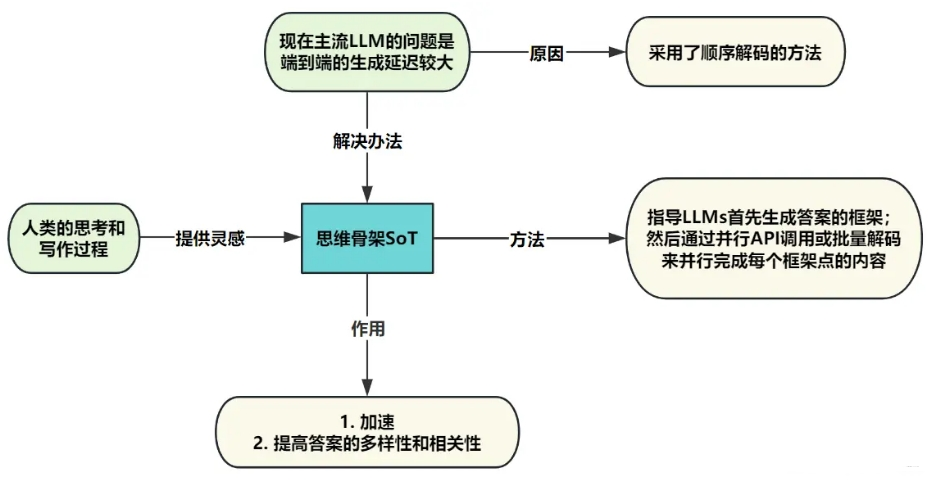


📚 主要参考资料：
- ICLR 2024 - Skeleton-of-Thought: Large Language Models Can Do Parallel Decoding，https://openreview.net/forum?id=mqVgBbNCm9

- 大模型速度狂飙 2.39 倍！清华联手微软首提 SoT，让 LLM 思考更像人类，https://mp.weixin.qq.com/s/9t1opfhUYm3yJuEoKPvVuQ，

- 思维骨架 SoT 如何提升 LLM 的速度？丨论文解读，https://juejin.cn/post/7269607286195699727